<a href="https://colab.research.google.com/github/RegisVargas/Multifractal-Model-of-Asset-Returns-MMAR-for-Thesis/blob/master/Improving_the_multifractal_model_of_asset_returns_by_Hidden_Markov_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install fbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#the code for Multifractal Model of Asset Returns was obtained from https://github.com/Deckstar/Multifractal-Model-of-Asset-Returns-MMAR-for-Thesis
from fbm import FBM
from fbm import fbm, fgn, times
from fbm import MBM
from fbm import mbm, mgn, times
import math
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import fsolve
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import clear_output
from datetime import datetime
q=[0.01, 0.1, 0.2, 0.3, 0.4, 
   0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 
   1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 
   1.5, 1.55, 1.6, 1.65, 1.7, 1.75, 
   1.8, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 
   1.9, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.985, 1.99, 
   1.991, 1.992, 1.993, 1.994, 1.995, 1.996, 1.997, 1.998, 1.999, 
   2.0, 
   2.001, 2.002, 2.003, 2.004, 2.005, 2.006, 2.007, 2.008, 2.009, 
   2.01, 2.015, 2.02, 2.025, 
   2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 
   2.1, 2.15, 2.2, 2.25, 2.3, 2.35, 2.4, 2.45, 2.5, 
   2.6, 2.7, 2.8, 2.9, 
   3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 
   4.0, 4.5, 
   5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 
   12.5, 15.0, 17.5, 20.0, 22.5, 25.0, 27.5, 
   30.0]
class Asset:
    #you need to define days_simu as as global variable based on the days of simulation, see the next cell for details
    def __init__(self, ticker):
        self.ticker = ticker
        self.data = None
        self.log_return = None
        self.XT = None
        self.partition = None
        self.tau_regression = None
        self.tau_q = None
        self.f_a = None
        self.H = None
        self.LAMBDA = None
        self.SIGMA_VARIANCE = None
        self.b = 2
        self.simulated_xt_array = None

    def get_data(self):
        return self.data
    def download_data(self, start_date, end_date):
        self.data = yf.download(self.ticker, start=start_date, end=end_date)
        self.log_return = self.evaluate_log_return()
        self.XT= np.log(self.data['Adj Close']) - np.log(self.data['Adj Close'][0])
    def evaluate_log_return(self):
        return np.log(1 + self.data['Adj Close'].pct_change())[1:]
    def partition_function(self,SIGMA = [[]], DELTA = None, Q = q):
        print("Calculating the partition function...\nThis step will take quite a while... so strap yourself in...\n")
        SIGMA=[[0 for x in range(len(DELTA))] for y in range(len(Q))]
        for k in range (0, len(Q)):
            if k%30==0:
                print("calculating i=" + str(k) + ' out of ' + str(len(Q)-1))
            for j in range (0,len(DELTA)):
                for i in range (0,len(self.XT)-1):
                    if i < int(len(self.XT)/DELTA[j]):
                        SIGMA[k][j]=SIGMA[k][j] + abs(self.XT[i*DELTA[j]+DELTA[j]]-self.XT[i*DELTA[j]])**Q[k]

        SIGMA=pd.DataFrame(SIGMA)
        
        for i in range (0,len(Q)):
            SIGMA.rename(index={SIGMA.index[i]:Q[i]}, inplace=True)
        for i in range (len(DELTA)-1,-1,-1):
            SIGMA.rename(columns={SIGMA.columns[i]:DELTA[i]}, inplace=True)
        
        print("Done! Your partition function is ready!\n")
        self.partition = SIGMA
    def plot_ln_Sq(self, DELTA):
      colors = ["blue","black","yellow","red","green"]
      variation_qs = [q.index(0.5),q.index(1),q.index(1.5),q.index(2.0),q.index(2.5)]
      color_index=0
      for i in variation_qs:
          plt.plot(np.log(DELTA), np.log(list(self.partition.iloc[i])/self.partition[1][q[i]]), color = colors[color_index], label = str(q[i]))
          color_index += 1


      plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                ncol=6, mode="expand", borderaxespad=0., title = "q values")

      plt.xlabel('ln (delta_t)\n(the natural log of time increments)')
      plt.ylabel('ln ( Sq(delta_t) )\n(the natural log of the partition function)')

      plt.show()
    def scaling_function(self, Q = q, DELTA = None):
        self.tau_regression=pd.DataFrame(np.log(DELTA))
        self.tau_regression['LN_DELTA']=pd.DataFrame(np.log(DELTA))
        self.tau_regression['LN_T']=[np.log((days_simu - 1)) for x in range(len(DELTA))]
        self.tau_q=0
        TAU_Q=[0 for x in range(len(Q))]
        
        for i in range(0,len(Q)):
            TAU_Q[i]=((sm.OLS(endog=np.log(list(self.partition.iloc[i]/self.partition[1][Q[i]])), exog = self.tau_regression[['LN_DELTA','LN_T']], missing='drop')).fit()).params[0]
        
        TAU_Q=pd.DataFrame(TAU_Q)

        self.tau_q = TAU_Q
    def find_Hurst_exponent(self):
      first_index_greater_than_zero = self.tau_q[self.tau_q[0]>0].index[0]
      return "The H exponent is between "+str(1/q[first_index_greater_than_zero])+" and "+str(1/q[first_index_greater_than_zero-1])
    def estimate_multifractal_spectrum(self, Q = q, MIN_Q = 0, MAX_Q = 105):
      TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], self.tau_q[MIN_Q:MAX_Q], 2)
      
      F_A = [0 for x in range(len(q)-10)]
      p = [0 for x in range(len(q)-10)]
      
      a = TAU_Q_ESTIMATED[0][0]
      b = TAU_Q_ESTIMATED[1][0]
      c = TAU_Q_ESTIMATED[2][0]
      
      for i in range(0, len(q)-10):
          p[i] = 2*a*Q[i]+b
          F_A[i] = ((p[i]-b)/(2*a))*p[i] - (a*((p[i]-b)/(2*a))**2 + b*((p[i]-b)/(2*a)) + c)
      
      F_A = pd.DataFrame(F_A)
      F_A.rename(columns={F_A.columns[0]:"f(a)"}, inplace=True)
      F_A['p'] = p
      
      print("Using the range of q's from " + str(Q[MIN_Q]) + " to " + str(Q[MAX_Q]) + ":")
      print("The estimated parameters for tau(q) are: \n" + str(TAU_Q_ESTIMATED))
      print("\nThus, the estimated parameters for f(a) are: \n" + str(1/(4*a)) + ", \n"  + str((-2*b)/(4*a)) + ", \n"+ str((-4*a*c+b**2)/(4*a)))
      
      self.f_a = F_A
    def estimate_H_and_lognormal_parameters(self, Q = q, MIN_Q = 0, MAX_Q = 105):
        TAU_Q_ESTIMATED = np.polyfit(Q[MIN_Q:MAX_Q], self.tau_q[MIN_Q:MAX_Q], 2)
        
        def f(x):
            return TAU_Q_ESTIMATED[0][0]*x**2 + TAU_Q_ESTIMATED[1][0]*x + TAU_Q_ESTIMATED[2][0]
        
        temp = fsolve(f, [0,4])
        
        H = 1/temp
        self.H = H[0]
        self.LAMBDA = self.f_a['p'][0]/self.H
        self.SIGMA_VARIANCE = (2*(self.LAMBDA-1))/np.log(self.b)
    def lognormal_cascade(self,k, v,ln_lambda, ln_theta):
    
      k = k - 1

      m0 = np.random.lognormal(ln_lambda,ln_theta)
      m1 = np.random.lognormal(ln_lambda,ln_theta)
      M = [m0, m1]
      
      if (k >= 0):
          d=[0 for x in range(0,2)]
          for i in range(0,2):
              d[i] = self.lognormal_cascade(k, (M[i]*v), ln_lambda, ln_theta)
          
          v = d

      return v
    def MMAR(self, K, original_price_history, magnitude_parameter,GRAPH):
      print("Performing an MMAR simulation with parameters:\n\nH = " + str(self.H) + "\nlambda = " + str(self.LAMBDA) + "\nsigma = " + str(self.SIGMA_VARIANCE) + "\nfBm magnitude = " + str(magnitude_parameter)+ "\n")
      # --- CASCADE ---
      new_cascade = list(np.array(self.lognormal_cascade(k=K, v=1, ln_lambda = self.LAMBDA, ln_theta = self.SIGMA_VARIANCE)).flat)
      # --- TRADING TIME ---
      tradingtime = 2**K*np.cumsum(new_cascade)/sum(new_cascade)
      # --- FBM (Fractional Brownian Motion) ---
      new_fbm_class = FBM(n = 10*2**K+1, hurst = self.H, length = magnitude_parameter, method='daviesharte')
      new_fbm_simulation = new_fbm_class.fbm()
      if GRAPH == True:
          # --- CASCADE ---
          #plt.figure(figsize=(24,2))
          plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
          plt.title("Binomial Cascade")
          plt.xlabel("Conventional time\n(days)")
          plt.ylabel('"Mass"')
          plt.plot(new_cascade, color="crimson", linewidth=0.5)
          plt.show()


          # --- TRADING TIME ---
          plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
          plt.yticks(np.arange(0, 2**(K)+1, 2**(K-3)))
          plt.title("Trading time\n(normalized)")
          plt.xlabel("Conventional time\n(days)")
          plt.ylabel('"Trading time"\n(\u03B8 (t), normalized)')
          plt.plot(tradingtime, color="orangered")

            
          # --- FBM (Fractional Brownian Motion) ---

          plt.figure(figsize=(24,2))
          plt.xticks(np.arange(0, 10*2**(K)+1, 10*2**(K-3)))
          plt.title("Fractional Brownian Motion")
          plt.xlabel("t")
          plt.ylabel('fBm (t)')
          plt.plot(new_fbm_simulation, color="orange")
          plt.show()

          
      # --- MMAR XT's ---
      simulated_xt_array = [0 for x in range(0, len(tradingtime))]

      for i in range(0, len(tradingtime)):
          simulated_xt_array[i] = new_fbm_simulation[int(tradingtime[i]*10)]
      if GRAPH == True:
          plt.title("MMAR generated Xt")
          plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
          plt.xlabel("Time\n(days)")
          plt.ylabel('X(t)\n(Natural log growth since beginning)')
          plt.grid(visible=True)
          plt.fill_between(np.arange(0, 2**K, 1) , simulated_xt_array, color="darkviolet", alpha=0.2)
          plt.show()


        # --- PRICES ---
          plt.title("MMAR generated Price")
          plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
          plt.xlabel("Time\n(days)")
          plt.ylabel('Price level')
          plt.grid(visible=True)
          plt.fill_between(np.arange(0, 2**K, 1) , original_price_history[0]*np.exp(simulated_xt_array), color="limegreen", alpha=0.2)
          plt.show()

          
      # --- LN CHANGES ---
      ln_simulated_xt_array = [0 for x in range(0, len(simulated_xt_array)-1)]

      for i in range(1,len(simulated_xt_array)):
          ln_simulated_xt_array[i-1] = np.log((original_price_history[0]*np.exp(simulated_xt_array[i]))/(original_price_history[0]*np.exp(simulated_xt_array[i-1])))
      if GRAPH == True:         
          plt.figure(figsize=(24,5))
          plt.title("Price increments")
          plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
          plt.xlabel("Time\n(days)")
          plt.ylabel('Change\n(%)')
          plt.grid(visible=True)
          plt.plot(ln_simulated_xt_array, color="darkviolet", linewidth=0.5)
          plt.gca().set_yticklabels(['{:.0f}'.format(x*100) for x in plt.gca().get_yticks()]) 
          plt.show()
      print("The number of price increments that equal zero is: " + str(list(np.abs(ln_simulated_xt_array)).count(0)))
      
      # --- END ---
      self.simulated_xt_array = simulated_xt_array
    def __usual_monte_carlo(self, return_price_list, num_simulations, num_days):
        simulated_prices=[]
        simulated_returns=[]
        last_price = self.data['Adj Close'][-1]
        mean_daily_return = self.log_return.mean()
        var_daily_return = self.log_return.var()
        std_daily_return = self.log_return.std()
        daily_drift = mean_daily_return - (0.5 * var_daily_return)
        cumulative_returns = np.zeros(num_simulations)
        for i in range(num_simulations):
            daily_returns = np.exp(daily_drift + std_daily_return * np.random.normal(size=num_days))
            price_list = [last_price]
            return_list = []
            for j in range(num_days):
                price_list.append(price_list[-1] * daily_returns[j])
                return_list.append(daily_returns)
            if return_price_list:
              simulated_prices.append(price_list)
              simulated_returns.append(daily_returns)
            else:
              simulated_prices.append(price_list[-1])
              simulated_returns.append(return_list)
        return pd.DataFrame(simulated_returns), pd.DataFrame(simulated_prices)
    def __hmm_monte_carlo(self, return_price_list, num_simulations, num_days, n_states):
        simulated_prices=[]
        simulated_returns=[]
        last_price = self.data['Adj Close'][-1]
        model = GaussianHMM(n_components = n_states, covariance_type = "diag")
        model.fit(np.array(self.log_return).reshape(-1, 1))
        for i in range(num_simulations):
            daily_returns, _ = model.sample(n_samples = num_days)
            daily_returns = np.exp(daily_returns)
            daily_returns = np.array(daily_returns).reshape((days_simu,))
            price_list = [last_price]
            return_list = []
            for j in range(num_days):
              price_list.append(price_list[-1] * daily_returns[j])
              return_list.append(daily_returns)
            if return_price_list:
              simulated_prices.append(price_list)
              simulated_returns.append(daily_returns)
            else:
              simulated_prices.append(price_list[-1])
              simulated_returns.append(return_list)
        return pd.DataFrame(simulated_returns), pd.DataFrame(simulated_prices)
    def monte_carlo_simulation(self, kind_of_simulation, return_price_list, num_simulations, num_days, n_states = None):
      if kind_of_simulation == "usual":
        return self.__usual_monte_carlo(return_price_list, num_simulations, num_days)
      elif kind_of_simulation == "hmm":
        return self.__hmm_monte_carlo(return_price_list, num_simulations, num_days, n_states)

In [4]:
type(datetime.today().strftime('%Y-%m-%d'))

str

In [5]:
np.random.seed(123)
ticker = 'ADBE'
days_simu = 4096
ADBE_real = Asset(ticker)
ADBE_real.download_data('1900-01-01',datetime.today().strftime('%Y-%m-%d'))

[*********************100%***********************]  1 of 1 completed


In [6]:
start_date_real_ADBE = ADBE_real.get_data()[-days_simu:].index[0].strftime('%Y-%m-%d')

In [7]:
end_date_simu_ADBE = ADBE_real.get_data()[-2*days_simu:-days_simu].index[-1].strftime('%Y-%m-%d')

In [8]:
start_date_simu_ADBE = ADBE_real.get_data()[-2*days_simu-1:-days_simu].index[0].strftime('%Y-%m-%d')

In [9]:
ADBE_real = Asset(ticker)
ADBE_real.download_data(start_date_real_ADBE,datetime.today().strftime('%Y-%m-%d'))
ADBE_simu = Asset(ticker)
ADBE_simu.download_data(start_date_simu_ADBE, end_date_simu_ADBE)
real_log_returns = np.exp(ADBE_simu.evaluate_log_return())
num_simu=100

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
ADBE_real.get_data()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-02-15,38.720001,39.299999,38.340000,39.250000,39.250000,5954600
2007-02-16,39.480000,40.430000,39.220001,40.270000,40.270000,9257600
2007-02-20,40.090000,40.759998,39.500000,40.740002,40.740002,5092100
2007-02-21,40.520000,41.040001,40.509998,40.950001,40.950001,5482200
2007-02-22,40.970001,41.099998,40.230000,40.810001,40.810001,4425800
...,...,...,...,...,...,...
2023-05-17,345.359985,358.690002,345.119995,356.630005,356.630005,3560600
2023-05-18,357.000000,361.480011,356.450012,360.429993,360.429993,2896400
2023-05-19,363.000000,372.079987,361.359985,371.250000,371.250000,3855500


In [11]:
ADBE_simu.get_data()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-11-13,1.765625,1.781250,1.718750,1.765625,1.667044,7996800
1990-11-14,1.750000,1.828125,1.750000,1.828125,1.726054,6553600
1990-11-15,1.796875,1.875000,1.781250,1.851563,1.748183,14166400
1990-11-16,1.843750,1.859375,1.593750,1.625000,1.534271,32057600
1990-11-19,1.656250,1.750000,1.656250,1.718750,1.622786,8169600
...,...,...,...,...,...,...
2007-02-07,38.650002,38.849998,38.029999,38.150002,38.150002,4215200
2007-02-08,38.180000,38.400002,37.930000,38.049999,38.049999,3965100
2007-02-09,38.200001,38.340000,37.450001,37.680000,37.680000,4413100


In [12]:
simulated_returns_mc,simulated_prices_mc = ADBE_simu.monte_carlo_simulation(kind_of_simulation = "usual",return_price_list = True,num_simulations = num_simu, num_days = days_simu)
simulated_returns_hmm,simulated_prices_hmm = ADBE_simu.monte_carlo_simulation(kind_of_simulation = "hmm",return_price_list = True,num_simulations = num_simu, num_days = days_simu, n_states = 4)
dist_MC=0
dist_hmm=0
#print(len(simulated_returns))
for j in range(len(simulated_returns_mc)):
    pvalue_mc = stats.ks_2samp(np.array(real_log_returns), np.array(simulated_returns_mc.iloc[j]))[1]
    pvalue_hmm = stats.ks_2samp(np.array(real_log_returns), np.array(simulated_returns_hmm.iloc[j]))[1]
    if(pvalue_mc > 0.05):
      dist_MC += 1
      #print(pvalue)
      #print(dist_tx_MC)
    if(pvalue_hmm > 0.05):
      dist_hmm += 1
      #print(pvalue)
      #print(dist_tx_MC)
#dist_tx_MC = dist_tx_MC/len(simulated_returns)
print("dist_MC: ",dist_MC)
print("dist_hmm: ",dist_hmm)

dist_MC:  0
dist_hmm:  70


In [13]:
simulated_prices_mc.shape

(100, 4097)

In [14]:
days_simu

4096

In [15]:
#generating the delta_t, divisors of (days_simu-1)
delta_t = []
for j in range(1,(days_simu+1)):
  if (days_simu-1) % j == 0:
    delta_t.append(j)
delta_t = tuple(delta_t)
delta_t

(1,
 3,
 5,
 7,
 9,
 13,
 15,
 21,
 35,
 39,
 45,
 63,
 65,
 91,
 105,
 117,
 195,
 273,
 315,
 455,
 585,
 819,
 1365,
 4095)

In [16]:
ADBE_simu.partition_function(DELTA = delta_t)

Calculating the partition function...
This step will take quite a while... so strap yourself in...

calculating i=0 out of 120
calculating i=30 out of 120
calculating i=60 out of 120
calculating i=90 out of 120
calculating i=120 out of 120
Done! Your partition function is ready!



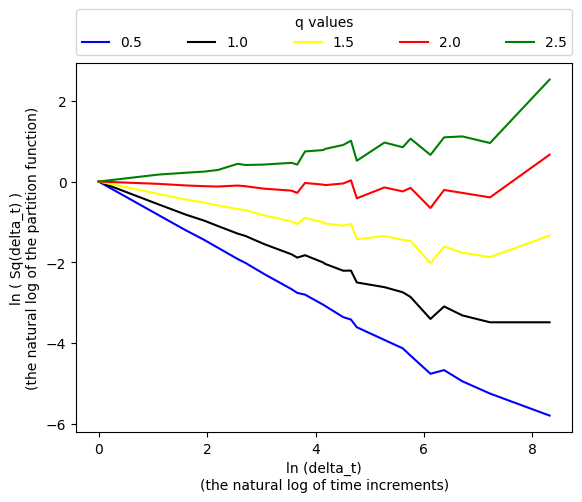

In [17]:
#below we plot the ln(Sq(delta_t)) X ln(delta_t). If there is multifractality, then the scale increases in a non-linear way for increases of q 
ADBE_simu.plot_ln_Sq(DELTA = delta_t)

In [18]:
#Estimating scaling function for ADBE
ADBE_simu.scaling_function(DELTA = delta_t)
hypothetical_tau_q = [0.5*x -1 for x in q]

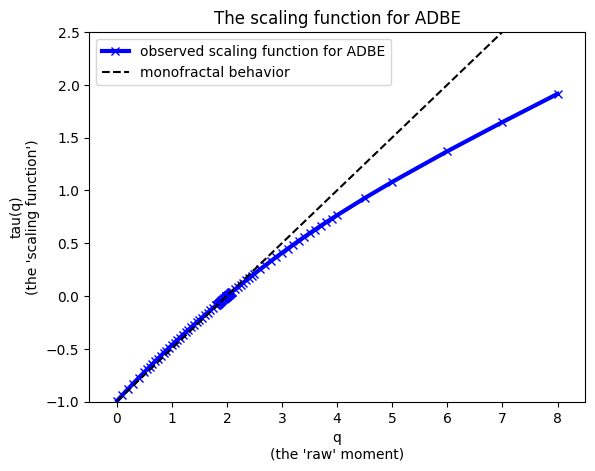

In [19]:
plt.title("The scaling function for ADBE")

plt.xlabel("q\n(the 'raw' moment)")
plt.ylabel("tau(q)\n(the 'scaling function')")

axes = plt.gca()
axes.set_xlim([-0.5,8.5])
axes.set_ylim([-1,2.5])

plt.plot(q[0:111], ADBE_simu.tau_q[0:111], color="blue",linewidth=3, marker="x", label="observed scaling function for ADBE")
plt.plot(q[0:111], hypothetical_tau_q[0:111], color="black", linestyle='--', label="monofractal behavior")
plt.legend()
plt.show()

In [20]:
ADBE_simu.find_Hurst_exponent()

'The H exponent is between 0.49875311720698257 and 0.499001996007984'

In [21]:
ADBE_simu.estimate_multifractal_spectrum()

Using the range of q's from 0.01 to 4.0:
The estimated parameters for tau(q) are: 
[[-0.02839348]
 [ 0.55213952]
 [-0.9924559 ]]

Thus, the estimated parameters for f(a) are: 
-8.804839636297162, 
9.722999849265397, 
-1.691770334945856


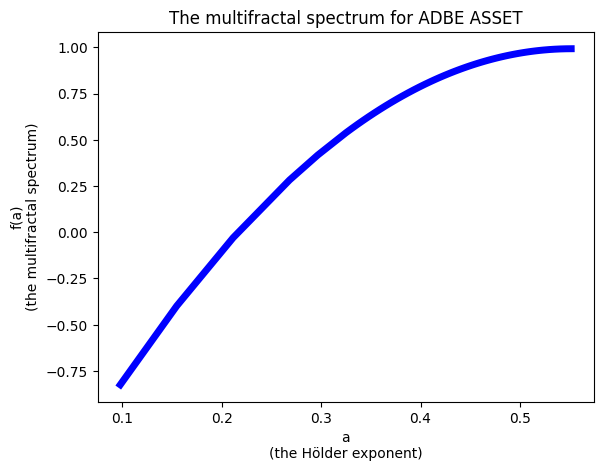

In [22]:
plt.title("The multifractal spectrum for ADBE ASSET")

plt.xlabel("a\n(the Hölder exponent)")
plt.ylabel('f(a)\n(the multifractal spectrum)')

# axes = plt.gca()
# axes.set_xlim([0.2,0.7])
# axes.set_ylim([0,1.1])

plt.plot(ADBE_simu.f_a['p'],ADBE_simu.f_a['f(a)'], color="blue",linewidth=5);

In [23]:
# estimate	 the	 log-normal	 distribution	 parameters	 for	 the	multiplicative	 cascade. It's here that we apply the HMM in the new methodology
ADBE_simu.estimate_H_and_lognormal_parameters()

In [24]:
print(ADBE_simu.H, ADBE_simu.LAMBDA, ADBE_simu.SIGMA_VARIANCE)

0.49900372715683183 1.1053457515582055 0.30396358670348766


In [25]:
np.random.lognormal(1.2778448866383225,0.8016908801789282)

2.7975960461381386

In [26]:
model = GaussianHMM(n_components = 4, covariance_type = "diag")
model.fit(np.array(ADBE_simu.f_a['p']).reshape(-1, 1))


GaussianHMM(n_components=4)

The difference in our methodology lies in the binomial cascade. In MMAR, random realizations of a lognormal distribution are used, whose parameters were estimated from the multifractal spectrum. In the model proposed by this work, we fit a 4-state hidden Markov model in the multifractal spectrum and use this model for the random generation of trading times. The estimation of the parameters by the traditional method is deterministic, since the parameters of the lognormal are obtained through the resolution of well-defined formulas that consider the data obtained from the multifractal spectrum. Our approach is probabilistic, as it maximizes the likelihood function from a sample using the expectations maximization algorithm, which adapts to the specific return data of each asset, so it is to be expected that Monte Carlo simulations produced from our methodology present a better performance than those obtained through standard Monte Carlo simulations.

Performing an MMAR simulation with parameters:

H = 0.49900372715683183
lambda = 1.1053457515582055
sigma = 0.30396358670348766
fBm magnitude = 0.15



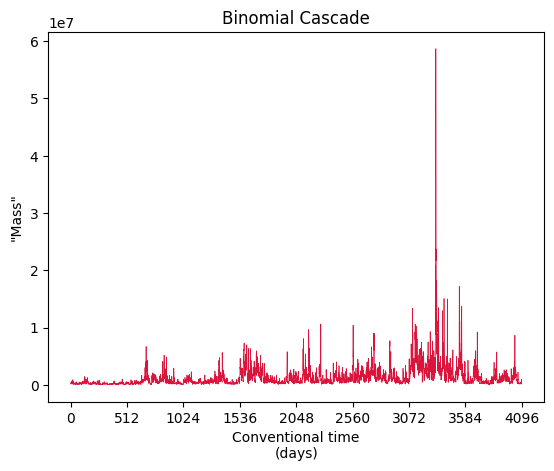

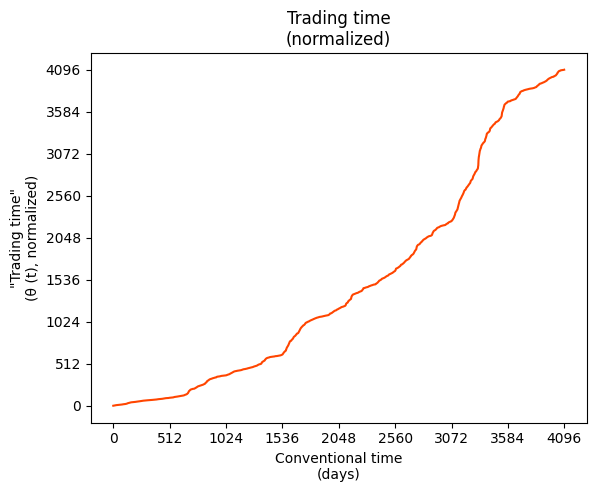

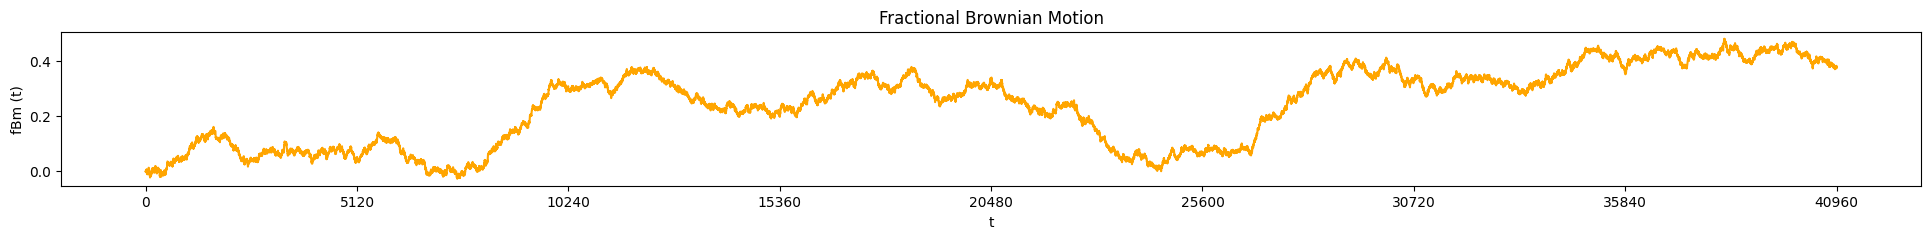

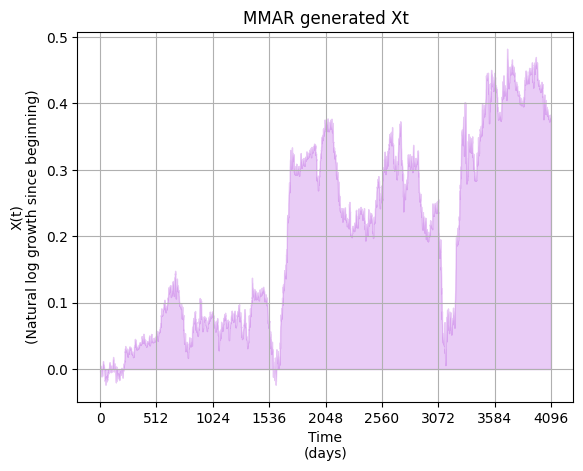

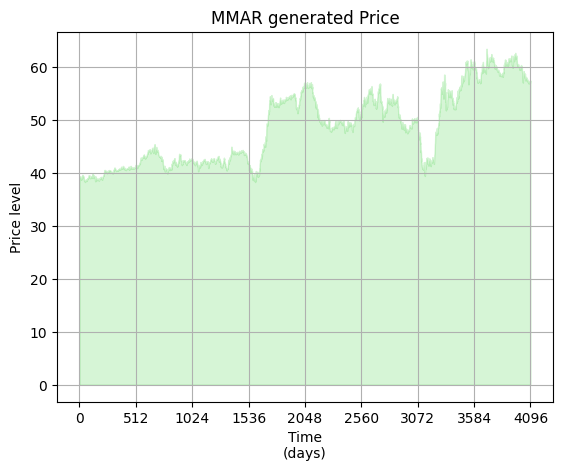

<ipython-input-3-c371519531fb>:241: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x*100) for x in plt.gca().get_yticks()])


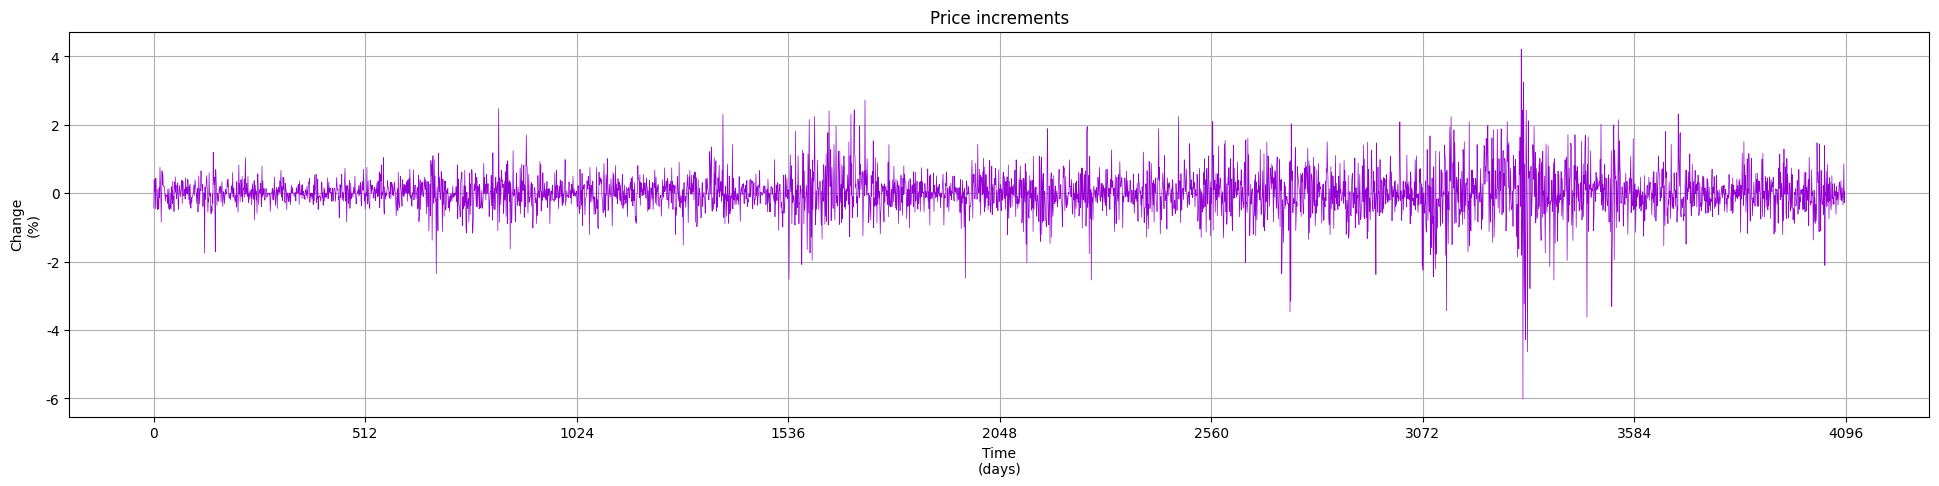

The number of price increments that equal zero is: 84


In [27]:
ADBE_simu.MMAR(12, ADBE_real.data['Adj Close'] , 0.15, True)

In [28]:
2**12

4096

In [29]:
attempt_length = 1000

attempt = pd.DataFrame([0 for x in range(0,2**13)])

magnitude_NORWAY = 0.10

for i in range(0,attempt_length):
    ADBE_simu.MMAR(12, ADBE_real.data['Adj Close'] , 0.15, False)
    attempt[i] = pd.DataFrame(ADBE_simu.simulated_xt_array)
    if (i+1)%10 == 0:
      clear_output()
attempt

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.000661,0.017339,-0.002659,-0.004340,-0.000853,-0.000609,-0.009687,-0.015615,0.000926,0.005341,...,-0.001866,0.004268,-0.000310,0.005883,0.003205,0.004800,0.001306,-0.003579,0.004221,0.003002
1,0.003170,0.015365,0.002510,-0.009309,0.003604,0.003937,-0.009242,-0.012625,0.000042,0.002584,...,0.001540,0.004753,-0.002636,0.004274,0.004759,0.002159,0.004019,-0.002702,-0.001188,-0.000360
2,0.009103,0.013701,-0.008286,-0.008483,0.005255,0.005669,-0.014007,-0.012156,0.008660,0.024356,...,0.000349,0.006590,0.000113,0.003417,0.009811,0.002187,0.008854,-0.003885,-0.006584,0.000097
3,0.005022,0.002242,0.001127,-0.017102,0.006406,0.009745,-0.010080,-0.018709,0.001687,0.027304,...,0.003809,0.007024,-0.005096,0.010558,0.011424,0.004672,0.015410,-0.006098,-0.010414,0.004101
4,0.009544,-0.001779,0.000886,-0.013549,0.003715,0.007843,-0.005647,-0.001482,0.002382,0.027663,...,-0.000269,0.007797,-0.011124,0.012734,0.024850,-0.009579,0.004615,-0.005203,-0.008002,-0.000915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
np.exp(attempt)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.999339,1.017490,0.997345,0.995670,0.999148,0.999391,0.990360,0.984506,1.000927,1.005355,...,0.998136,1.004277,0.999690,1.005900,1.003210,1.004811,1.001307,0.996428,1.004229,1.003006
1,1.003175,1.015484,1.002513,0.990734,1.003610,1.003945,0.990801,0.987454,1.000042,1.002588,...,1.001541,1.004764,0.997367,1.004283,1.004770,1.002161,1.004027,0.997302,0.998812,0.999640
2,1.009145,1.013795,0.991748,0.991552,1.005269,1.005685,0.986090,0.987918,1.008697,1.024655,...,1.000349,1.006612,1.000113,1.003423,1.009859,1.002190,1.008894,0.996123,0.993438,1.000097
3,1.005034,1.002245,1.001128,0.983043,1.006426,1.009792,0.989970,0.981465,1.001689,1.027680,...,1.003816,1.007049,0.994917,1.010614,1.011490,1.004683,1.015529,0.993920,0.989640,1.004109
4,1.009590,0.998223,1.000886,0.986543,1.003722,1.007873,0.994369,0.998519,1.002385,1.028049,...,0.999731,1.007827,0.988938,1.012816,1.025161,0.990466,1.004626,0.994810,0.992030,0.999086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
np.array(ADBE_real.data['Adj Close'][0]*np.exp(attempt[0])[0:99]), np.array(ADBE_real.data['Adj Close'][0:99])

(array([39.22406019, 39.37460195, 39.60892894, 39.44759886, 39.62640255,
        39.66802681, 39.76145376, 39.56828968, 39.86879276, 39.84004317,
        39.97791214, 40.26113226, 40.28048079, 40.57739731, 40.57076629,
        40.63338634, 41.19268444, 41.18869474, 41.33356766, 41.4039834 ,
        41.39314992, 41.50088251, 41.70641579, 41.94525475, 42.29301235,
        42.30919168, 42.32624548, 42.36121298, 42.54346639, 42.59230124,
        42.9607581 , 42.76555069, 43.15868079, 43.11836419, 43.402092  ,
        43.39036435, 43.2349915 , 43.28665893, 43.18769476, 43.17693409,
        42.94243206, 43.09776524, 42.95836337, 43.07250353, 43.27985802,
        43.33393517, 43.39027461, 43.4704163 , 43.41148498, 43.89477079,
        43.70326928, 43.6814197 , 43.66042869, 43.7188553 , 43.62047384,
        43.723179  , 43.68895537, 43.8269837 , 43.67568704, 43.62850505,
        43.53594291, 43.47205199, 43.19428571, 43.62221546, 43.59003656,
        43.61840556, 43.65189997, 43.61451244, 43.6

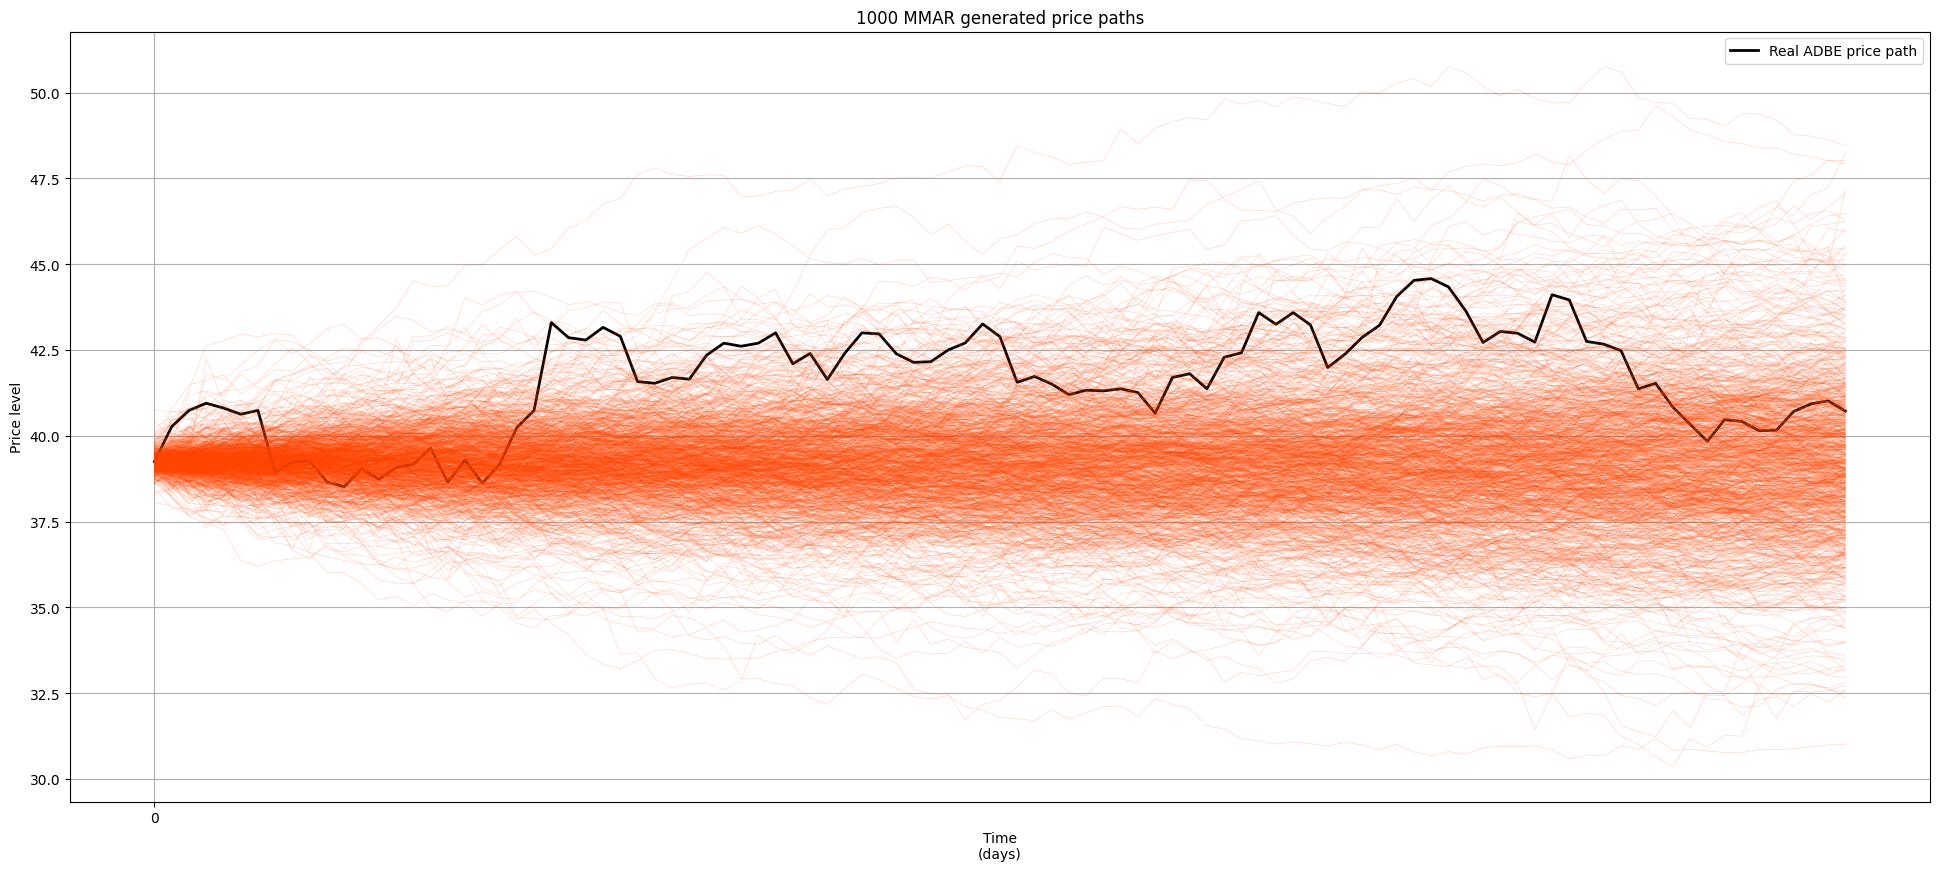

In [35]:
plt.figure(figsize=(24,10))

plt.plot(np.array(ADBE_real.data['Adj Close'])[0:99], color="black", linewidth=2, label="Real ADBE price path")

plt.legend()

for i in range(0,len(attempt.columns)):
    K=12
    plt.title(str(attempt_length) + " MMAR generated price paths")
    plt.xticks(np.arange(0, 2**(K)+1, 2**(K-3)))
    plt.xlabel("Time\n(days)")
    plt.ylabel('Price level')
    plt.grid(visible = True)
    plt.plot(np.arange(0, 2**K, 1)[0:99] , ADBE_real.data['Adj Close'][0]*np.exp(attempt[i])[0:99], color="orangered", linewidth=0.5, alpha=0.2)

plt.show()

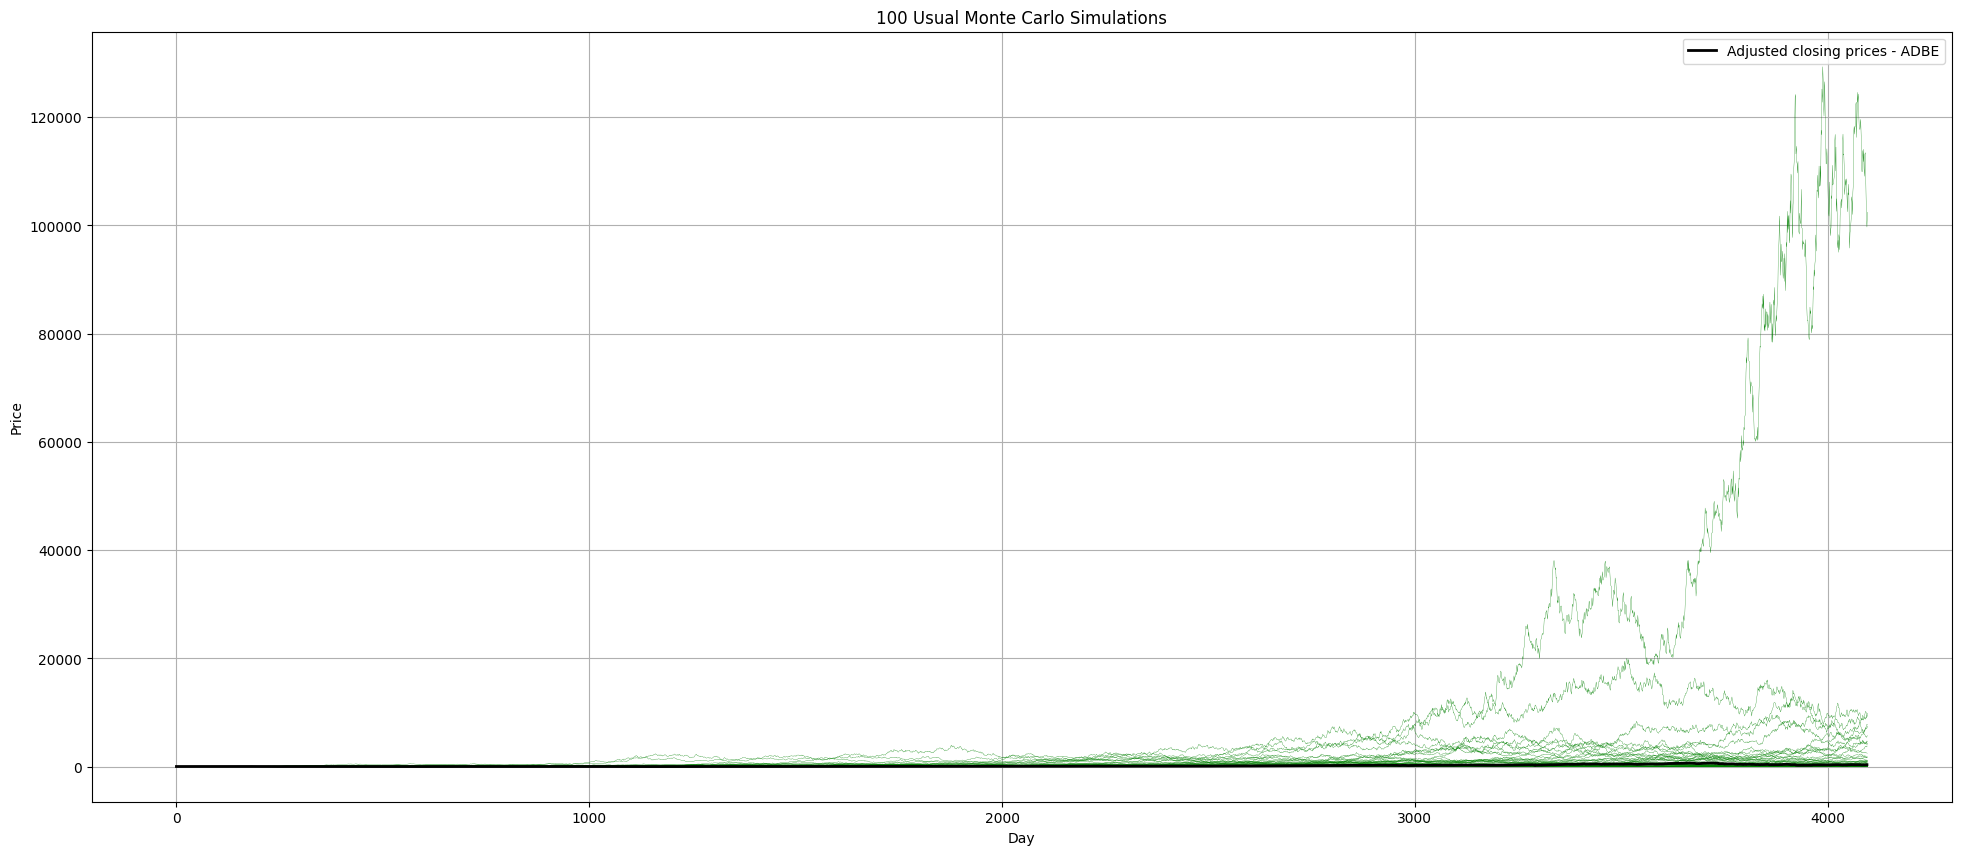

In [33]:
plt.figure(figsize=(24,10))
for i in range(len(simulated_prices_mc)):
  plt.plot(simulated_prices_mc.iloc[i], color="green", linewidth=0.2)
plt.plot(pd.Series(np.array(ADBE_real.get_data()['Adj Close'])), color="black", linewidth=2,label="Adjusted closing prices - ADBE")
plt.legend()
plt.title(str(num_simu) + " Usual Monte Carlo Simulations")
plt.grid(visible=True)
plt.xlabel("Day")
plt.ylabel('Price')
plt.show()

100


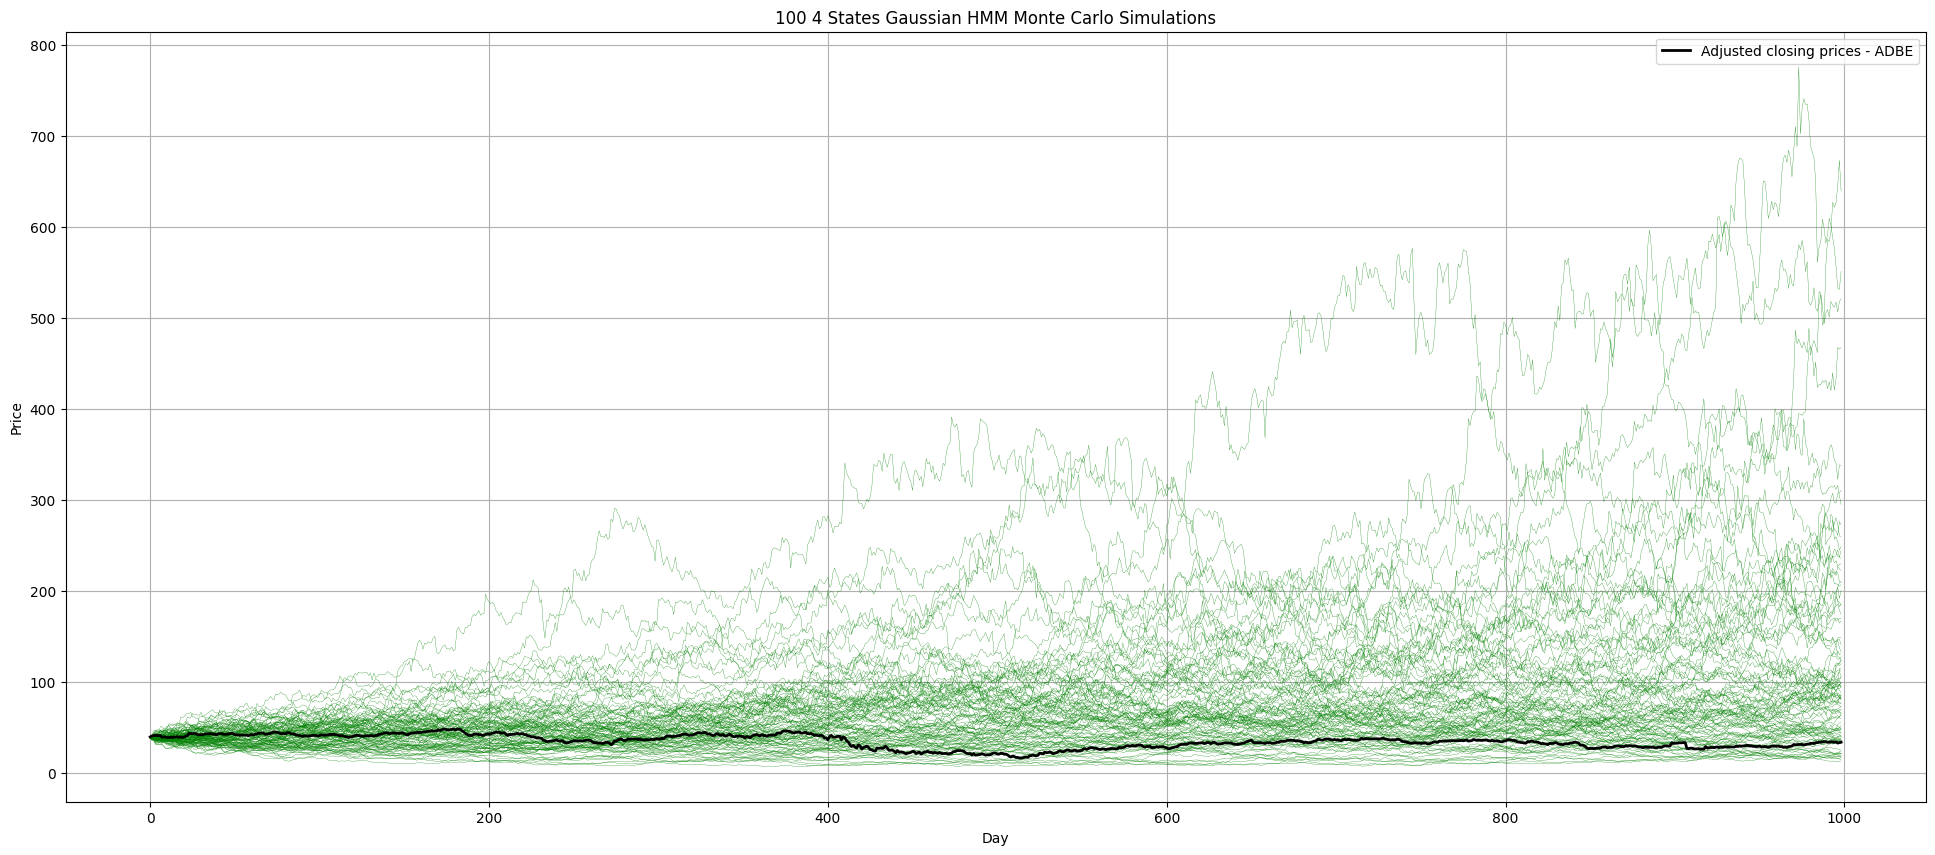

In [34]:
plt.figure(figsize=(24,10))
print(len(simulated_prices_hmm))
for i in range(len(simulated_prices_hmm)):
  plt.plot(simulated_prices_hmm.iloc[i][0:999], color="green", linewidth=0.2)
plt.plot(pd.Series(np.array(ADBE_real.get_data()['Adj Close'][0:999])), color="black", linewidth=2,label="Adjusted closing prices - ADBE")
plt.legend()
plt.title(str(num_simu) + " 4 States Gaussian HMM Monte Carlo Simulations")
plt.grid(visible=True)
plt.xlabel("Day")
plt.ylabel('Price')
plt.show()